In [1]:
import numpy as np
import pandas as pd
import math
from datetime import datetime
import matplotlib.pyplot as plt

### Load Justice-centered data into pandas df

We use the "Full" dataset to reduce the likelihood of predicting on an unseen justice

In [2]:
trainX = pd.read_csv('../data/trainX_justice_full.csv')
trainY = pd.read_csv('../data/trainY_justice_full.csv')

p = 0.1 # Proportion to shift to test set
cases = np.unique(trainX['caseId']) # list of all the cases (randomly select to choose as test)
num_test = int(np.floor(cases.shape[0] * p))

indices = np.random.randint(0, cases.shape[0], num_test)
mask = np.ones_like(cases,dtype=np.bool)
mask[indices] = 0 
test_cases = cases[indices]
train_cases = cases[mask]
train_idx = trainX.loc[trainX['caseId'].isin(train_cases)].index
test_idx = trainX.loc[trainX['caseId'].isin(test_cases)].index
tmpX = trainX
tmpY = trainY
testX = tmpX.loc[test_idx, :].copy().reset_index()
testY = tmpY.loc[test_idx, :].copy().reset_index()
trainX = tmpX.loc[train_idx, :].copy().reset_index()
trainY = tmpY.loc[train_idx, :].copy().reset_index()
tmpX = tmpY = -1

### Variables (from preprocessing)

In [3]:
# column names by category
id_variables = [
    u'justice', u'justiceName', #Name and unique ID
    u'caseId', u'docketId', u'caseIssuesId', u'voteId',
    u'usCite', u'sctCite', u'ledCite', u'lexisCite',
    u'docket']
     
# bg_variables = [
#     u'petitioner', u'petitionerState',
#     u'respondent', u'respondentState', u'jurisdiction',
#     u'adminAction', u'adminActionState', u'threeJudgeFdc',
#     u'caseOrigin', u'caseOriginState', u'caseSource',
#     u'caseSourceState', u'lcDisagreement', u'certReason',
#     u'lcDisposition', u'lcDispositionDirection',
# ]  
       
bg_variables = [
    u'petitioner', u'petitionerState',
    u'respondent', u'respondentState', 
    u'jurisdiction',
    u'adminAction', u'adminActionState', u'threeJudgeFdc',
    u'caseOrigin', u'caseOriginState', u'caseSource',
    u'caseSourceState', u'lcDisagreement', u'certReason',
    u'lcDisposition', u'lcDispositionDirection',
]

chrono_include = [u'naturalCourt', u'chief']
chrono_donotinclude = [u'dateDecision', u'decisionType', u'term',
                       u'dateArgument', u'dateRearg']
chrono_variables = chrono_include + chrono_donotinclude

substantive_variables = [
    u'issue',
    u'issueArea', 
#     u'decisionDirection',
    u'decisionDirectionDissent', 
    u'authorityDecision1',
    u'authorityDecision2', 
    u'lawType', u'lawSupp', u'lawMinor']

outcome_variables = [
    u'declarationUncon', u'caseDisposition',
    u'caseDispositionUnusual', u'partyWinning', u'precedentAlteration',  
    u'firstAgreement', u'secondAgreement']

voting_variables = [u'voteUnclear', u'majOpinWriter', u'majOpinAssigner',
                    u'splitVote', u'majVotes', u'minVotes',  u'vote', u'opinion',
                    u'direction', u'majority']

# column names for inclusion in train/test
feature_cols = substantive_variables + bg_variables + chrono_include
label_cols = outcome_variables + voting_variables

## Decide on outcome vector

## One-hot encode select categorical variables
#### + impute nulls

In [4]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from scipy.sparse import csr_matrix, hstack

class Categorical(object):
    '''Class to manage all the data'''
    def __init__(self, df, outcomes, ohe_threshold = 0.08):
        self.names = df['justiceName']
        self.n_justices = len(self.names.unique())
        self.ids = df[id_variables].copy()
        self.justice_ids = self.ids['justice'].unique()
        self.features = df[feature_cols].copy()
        self.cont_feat = pd.DataFrame()
        self.outcomes = outcomes[label_cols].copy()
        
        #Impute Values
        self.ids = self.ids.fillna(-1) 
        self.features = self.features.fillna(-1)
        self.outcomes = self.outcomes.fillna(-1) 
        
        # Select the categorical features to OHE
        self.ohe_vars = bg_variables
        self.id_vars = id_variables
        self.out_vars = label_cols
        self.cont_vars = [] # will be appended later when generated
        
        
        # Split the data into training and test portions
        self.split_dataset()

        #Label Encode select categorical variables
        self.LE()
        
        #Label Encode the outcome variables
        self.LE_Outcomes()
        #OHE the categorical data
        self.OHE()
        
    def split_dataset(self, p=0.1):
        
        cases = np.unique(self.ids['caseId']) # list of all the cases (randomly select to choose as test)
        num_test = int(np.floor(cases.shape[0] * p))        
        indices = np.random.randint(0, cases.shape[0], num_test)
        mask = np.ones_like(cases,dtype=np.bool)
        mask[indices] = 0 
        test_cases = cases[indices]
        train_cases = cases[mask]
        
        #Select row indices
        train_idx = self.features.loc[self.ids['caseId'].isin(train_cases)].index
        test_idx = self.outcomes.loc[self.ids['caseId'].isin(test_cases)].index
        
        #Ensure clean superset
        tmpX = self.features.copy()
        tmpI = self.ids.copy()
        tmpY = self.outcomes.copy()
        
        #Divide and reset indices of test and train sets
        self.test_feat = tmpX.loc[test_idx, :].copy().reset_index(drop=True)
        self.test_id = tmpI.loc[test_idx, :].copy().reset_index(drop=True)
        self.test_l = tmpY.loc[test_idx, :].copy().reset_index(drop=True)
        self.train_feat = tmpX.loc[train_idx, :].copy().reset_index(drop=True)
        self.train_id = tmpI.loc[train_idx, :].copy().reset_index(drop=True)
        self.train_l = tmpY.loc[train_idx, :].copy().reset_index(drop=True)
        self.train_idx = train_idx
        self.test_idx = test_idx
        
    def LE(self):
        '''Label Encode ALL variables (to give reasonable feautures) '''  
        le = {}  #keep le global so we may inverse_transform if necessary
        for c in self.features.columns: 
            le[c] = LabelEncoder()
            self.features.loc[:,c] = le[c].fit_transform(self.features[c])
            self.train_feat.loc[:, c] = le[c].transform(self.train_feat[c])
            self.test_feat.loc[:, c] = le[c].transform(self.test_feat[c])
        self.le = le # label encoder (useful for reverse transforming also)
        
    def LE_Outcomes(self):
        le = {}
        for c in self.outcomes.columns:
            le[c] = LabelEncoder()
            self.outcomes.loc[:,c] = le[c].fit_transform(self.outcomes[c])
            self.train_l.loc[:, c] = le[c].transform(self.train_l[c])
            self.test_l.loc[:, c] = le[c].transform(self.test_l[c])   
        self.le_out = le
        
    def OHE(self):
        self.ohe = OneHotEncoder()
        self.ohe.fit(self.features)
        self.feat_ohe = self.ohe.transform(self.features)

        self.train_feat_ohe =  self.ohe.transform(self.train_feat) 
        self.test_feat_ohe = self.ohe.transform(self.test_feat)
    
    def decode_feature(self, col):
        '''Un-OHE a feature'''
        if col not in self.features.columns:
            print "Nota  legal feature. Aborting"
            return None
        le = self.le[self.features.index(col)]
        return le.inverse_transform(self.features[col])
    
    def decode_outcome(self, col):
        '''Un-OHE a feature'''
        if col not in self.outcomes.columns:
            print "Nota  legal feature. Aborting"
            return None
        le = self.le_out[self.outcomes.index(col)]
        return le.inverse_transform(self.outcomes[col])
    
#     def orig_cat(self): # Not important since I cache the values, but keep for possible future functions
#         '''Returns the original array of the OHE encoded csr array
#             (requires the original one-hot encoder fit to the dataset) '''
#         return np.array([self.ohe.active_features_[col] for col in 
#                             self.features.sorted_indices().indices]).reshape(self.n_samples, self.n_cat_features) \
#                                 - self.ohe.feature_indices_[:-1]


    def isolate_justice(self, ID, which='all'):
        '''Return indices correlated with votes of a single justice '''
        
        #Check if ID is a legal label-encodded justice id
        if ID not in self.ids['justice'].unique():
            print "Error: {0} not a legal justice ID".format(ID)
            return None        
        if which == 'all':
            return self.ids.loc[self.ids['justice'] == ID].index
        elif which == 'train':
            return self.train_id.loc[self.train_id['justice'] == ID].index
        elif which == 'test':
            return self.test_id.loc[self.test_id['justice'] == ID].index
        else:
            print "Error isolating justice"
            return None
       
        
    def merge_Xmatrices(self, rows):
        return hstack((csr_matrix(self.other.values[rows,:]), self.cat_ohe[rows,:]))
    
    
    def justice_X(self, ID):
        return self.merge_Xmatrices(rows=self.isolate_justice(ID))
    
    def justice_Y(self, ID, which='train'):
        if which == 'train':
            return self.train_l.loc[self.isolate_justice(ID, which), :]
        elif which == 'test':
            return self.test_l.loc[self.isolate_justice(ID, which), :]
        elif which =='all':
            return self.outcomes.loc[self.isolate_justice(ID, which), :]
        else:
            print "Err in justice_Y"
            return None
    
    
    def add_feature(self, name, d, categorical=True):
        '''Takes as input a dictionary of (justiceId: value) pairs. '''
        typ = type(d.values()[0]) # Try to guess dtype (not really necessary in this sandbox, but hey)
        col = np.zeros(self.features.shape[0], dtype=typ)
        
        #Check if repeatcolumn
        if name in self.le:
            print "Header Name already in use. Aborting."
            return None
        
        #Input values
        for j, val in d.items():
            indices = self.isolate_justice(j)
            col[indices] = val
       
        
        if categorical:
            self.le[name] = LabelEncoder()
            col = self.le[name].fit_transform(col)
            col = pd.DataFrame({name: col})
            self.ohe_vars.append(name)
            self.features = pd.concat((self.features, col), axis=1)
            col_train = col.loc[self.train_idx, :].copy().reset_index(drop=True)
            col_test = col.loc[self.test_idx, :].copy().reset_index(drop=True)
            self.train_feat = pd.concat((self.train_feat, col_train), axis=1)
            self.test_feat = pd.concat((self.test_feat, col_test), axis=1)
            self.OHE()
            
        else: # Continuous
            col = pd.DataFrame({name: col})
            self.cont_vars.append(name) #Only index continuous variables
            if  np.sum(self.cont_feat.shape ) == 0:
                self.cont_feat = col
                col_train = col.loc[self.train_idx, :].copy().reset_index(drop=True)
                col_test = col.loc[self.test_idx, :].copy().reset_index(drop=True)
                self.train_feat_cont = col_train
                self.test_feat_cont = col_test
            else:
                self.cont_feat = pd.concat((self.cont_feat, col), axis=1)
                col_train = col.loc[self.train_idx, :].copy().reset_index(drop=True)
                col_test = col.loc[self.test_idx, :].copy().reset_index(drop=True)
                self.train_feat_cont = pd.concat((self.train_feat_cont, col_train), axis=1)
                self.test_feat_cont = pd.concat((self.test_feat_cont, col_test), axis=1)
                
                
    def check_dims(self):
        print self.train_feat.shape
        print self.test_feat.shape
        print self.features.shape
        print self.train_feat_ohe.shape
        print self.test_feat_ohe.shape
        print self.feat_ohe.shape
        print self.train_l.shape
        print self.test_l.shape
        print self.outcomes.shape
        
    def feature_array(self, which='train', OHE=False):
        if OHE:
            if which == 'train':
                return np.concatenate((self.train_feat_ohe.toarray(), self.train_feat_cont), axis=1)
            elif which == 'test':
                return np.concatenate((self.test_feat_ohe.toarray(), self.test_feat_cont), axis=1)
            else:
                return np.concatenate((self.feat_ohe, self.feat_cont), axis=1)
        else:
            if which == 'train':
                return np.concatenate((self.train_feat.values, self.train_feat_cont), axis=1)
            elif which == 'test':
                return np.concatenate((self.test_feat.values, self.test_feat_cont), axis=1)
            else:
                return np.concatenate((self.features.values, self.feat_cont), axis=1)
        
        
    def label_array(self, which='train'):
        if which == 'train':
            return self.train_l['direction']
        elif which == 'test':
            return self.test_l['direction']
        else:           
            return self.outcomes['direction']
        
def index_outcome(arr, col, columns):
    return arr[:, list(columns).index(col)]
      

## Create a categorical object

In [5]:
cat = Categorical(df = trainX, outcomes = trainY)

## Cluster justices into 2 groups based on likelihood to side with majority
### majMin

HHBurton:	86
JHarlan2:	91

Green (relatively more frequently side with majority):
HHBurton SAAlito JGRoberts SGBreyer RBGinsburg CThomas DHSouter AMKennedy AScalia SDOConnor WHRehnquist LFPowell HABlackmun WEBurger AFortas SSotomayor AJGoldberg PStewart SFReed BRWhite TCClark SMinton FMVinson WJBrennan EWarren EKagan 

Blue (relatively more likely to vote minority):
JHarlan2 JPStevens TMarshall FMurphy WBRutledge HLBlack CEWhittaker FFrankfurter WODouglas RHJackson

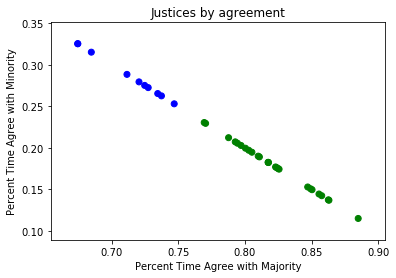

In [6]:
from sklearn.cluster import KMeans
#Toggle Values
col_title = "majMin"
display = True

# Create a dictionary to easily get name
name_to_id = { name: l for (name, l) in zip(cat.ids['justiceName'].unique(), cat.justice_ids)}
id_to_name = { l: name for (name, l) in zip(cat.ids['justiceName'].unique(), cat.justice_ids)}

def maj_min_norm(cat, justiceID):
    '''Return 2D vector representation where dim_0 is the percent time 
        voting with majority and dim_1 is percent voting with minority'''
    j = cat.justice_Y(justiceID, which='train')
    maj_min = index_outcome(j.values,'majority', cat.outcomes.columns)
#     print np.unique(maj_min)
    n = maj_min.shape[0]
    total = np.sum(maj_min == 2)
    return [float(total)/n, float(n-total)/n]
    
def majMin_cluster(df):
    justices = np.array([maj_min_norm(df, i) for i in df.ids['justice'].unique()])
    names = np.array([i for i in df.ids['justiceName'].unique()])
    kmeans = KMeans(n_clusters=2, init=np.array([[1, 0],[0, 1]]),n_init=1,  random_state=0).fit(justices)
#     kmeans = KMeans(n_clusters=2, random_state=0).fit(justices)
    colors = np.where(kmeans.labels_ == 1, 'b', 'g')
    # Group by 
    groups = np.array([[n, 1] if c else [n, 0] for (c, n) in zip(kmeans.labels_ == 1,names)])
    groups =  groups[groups[:, 1].argsort()]

    # Label-> Justice
    l_to_j = {}
    for i in range(groups.shape[0]):
        j = int(groups[i, 1]) 
        if j in l_to_j:
            l_to_j[j].append(name_to_id[groups[i, 0]])
        else:
            print "{0}:\t{1}".format(groups[i, 0], name_to_id[groups[i, 0]])
            l_to_j[j] = [name_to_id[groups[i, 0]]]
            

    print "\nGreen (relatively more frequently side with majority):"
    for name in l_to_j[0]:
        print id_to_name[name],
    print "\n\nBlue (relatively more likely to vote minority):"
    for name in l_to_j[1]:
        print id_to_name[name],

    j_to_l = {} #Justice -> Label dict
    for key, val in l_to_j.items():
        for j in val:
            j_to_l[j] = key
    if col_title not in df.ohe_vars:
        df.add_feature(col_title, j_to_l) # Add a "likely to vote with minority" variable

    # Plot results
    plt.scatter(justices[:, 0], justices[:, 1], c=colors)
    plt.title('Justices by agreement')
    plt.xlabel('Percent Time Agree with Majority')
    plt.ylabel('Percent Time Agree with Minority')
    plt.show()
    
majMin_cluster(cat)

## Shift it to JUST percentage majMin (more flexible)

In [7]:
col_title = 'majMinP'
    
def majMin(df):
    justices = np.array([maj_min_norm(df, i) for i in df.ids['justice'].unique()])
    names = np.array([i for i in df.ids['justice'].unique()])
    j_to_l = {}
    for n, v in zip(names, justices):
        j_to_l[n] = v[0]    
    df.add_feature(col_title, j_to_l, categorical=False)    
majMin(cat)

#### Note in the figure above that there are not distinct voting "Clusters", but it does seem that one may linearly separate the valuest

Question: Does it make sense that I am normalizing based on the total number of votes taken by a justice? Or should I normalize based on the total maj/min votes OVERALL?

## Now cluster based on Political inclination in each "issue" area

Cluster based on issues?

In [8]:
col_title = "idealogy"
def ideology_vector(cat, justiceID, vecSize):
    
    j_y = cat.justice_Y(justiceID, which='train')
#     j_ind = cat.isolate_justice(justiceID)
#     print j_y
#     print j_ind
    bias = index_outcome(j_y.values, 'direction', cat.outcomes.columns) # normalized lean (conservative | liberal) in this case
#     issue = np.array((cat.train_feat['issueArea'].values)[j_ind]) # IssueArea for the case
    issue = cat.train_feat['issueArea']
#     print issue
#     print bias
    bias[np.where(bias == 2)] = -1 # Recode s.t. -1 ~ liberal, 0, nan, 1 ~ conservative
    v = np.zeros(vecSize, dtype=float)
    t = np.zeros(vecSize, dtype=float)
    # Sum the total values
    for i in range(bias.shape[0]):
        v[issue[i]] = v[issue[i]] + bias[i]
        t[issue[i]] = t[issue[i]] + 1

    for i in range(vecSize):
        if t[i] > 0:
            v[i] = v[i] / t[i] # normalize by totals for each subject area
    return v # v is then an "ideology vector" we may use to cluster justices


n_areas = cat.le['issueArea'].classes_.shape[0] #Total general issue areas

j_ids = cat.ids['justice'].unique()
justices = np.array([ideology_vector(cat, i, n_areas) for i in j_ids])  

## Create 4 clusters 

In [9]:
#The center-of-mass for the KMeans on the training dataset
inVec = np.array([[ -0.0244026806527, -0.0558264238058, -0.156417287945, -0.10066429494,
          -0.323551771618, -0.069625587029, -0.469631185808, -0.0907648163676, 
          -0.029025230359, 0.189929474252, -0.177569697334, 0.0, 
          -0.365343893194, -0.0555555555556, 0.0],
        [ -0.0133333333333, 0.401859299291, 0.203832291671, 0.261568177981,
         0.00348673717842, 0.67353353677, 0.233316362621, 0.141628144099,
         0.00683037700267, 0.341179056921, -0.0814992234008, 0.0,
         -0.392486004103, 0.0327272727273, 0.0],
        [ 0.0, -0.59649122807, -0.521739130435, -0.233333333333, -0.5, 
         1.0, 0.0, -0.5, -0.674418604651, 
         -0.216216216216, -0.15, 0.0, -0.777777777778, 0.0, 0.0],
        [ -0.0330782312925, -0.561335380182, -0.663705854674, -0.653772178576, 
         -0.634776987879, -0.333354629866, -0.633753229974, -0.31285542346, 
         -0.474041195724, 0.111838370646, -0.321520788452, 0.0, -0.342243821897, 0.0, 0.0]])



def idealogy_labels(justices):
    km = KMeans(n_clusters=4, init=inVec, n_init= 1, random_state=0).fit(justices)
#     km = KMeans(n_clusters=4, random_state=0).fit(justices)

    # colors = np.where(kmeans.labels_ == 1, 'b', 'g')
    labels = km.labels_
    n = labels.shape
    colors = np.empty(n, dtype=str)
    for i in range(n[0]): 
        if labels[i] == 0:
            colors[i] = 'g'
        elif labels[i] == 1:
            colors[i] = 'b'
        elif labels[i] == 2:
            colors[i] = 'r'
        else:
            colors[i] = 'm'
    return colors, labels, km

colors, labels, km_idea = idealogy_labels(justices)

In [10]:
print km_idea.cluster_centers_
print km_idea.cluster_centers_[km_idea.labels_[0]]

[[-0.07654321 -0.08210141 -0.15511122 -0.10678424 -0.13272273 -0.09259259
   0.01234568 -0.08142775 -0.13194112 -0.2072791  -0.04829156 -0.201186
  -0.07167151  0.          0.        ]
 [-0.01825397  0.15223597  0.05924695  0.14117364  0.11111529  0.34126984
  -0.03968254  0.11624241  0.13011358  0.12262525  0.17933359  0.16591081
   0.14654265  0.          0.        ]
 [ 0.48888889  0.31886127  0.3855364   0.34962121  0.35895062  0.19444444
  -0.08333333  0.30907331  0.30588786  0.31380685  0.23994709  0.27660765
   0.37209817  0.          0.        ]
 [-0.23703704 -0.42267964 -0.42985678 -0.50406305 -0.48859596 -0.4691358
  -0.2345679  -0.42422004 -0.46493143 -0.47433929 -0.23324579 -0.32412683
  -0.45155748  0.          0.        ]]
[-0.01825397  0.15223597  0.05924695  0.14117364  0.11111529  0.34126984
 -0.03968254  0.11624241  0.13011358  0.12262525  0.17933359  0.16591081
  0.14654265  0.          0.        ]


## Project onto top 2 principal components

(36, 15)


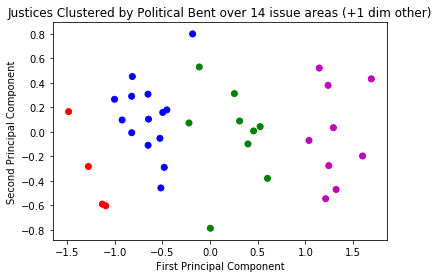

Adding bias


In [11]:
from sklearn.decomposition import PCA
#Toggle Values
col_title = "bias"
display = False

def idealogy_cluster(df, justices, colors, labels, name_to_id, id_to_name, test=True):
    pca = PCA()
    print justices.shape
    pca.fit(justices)
    justices_pca = pca.transform(justices)
    plt.scatter(justices_pca[:,0], justices_pca[:, 1], c=colors)
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.title('Justices Clustered by Political Bent over 14 issue areas (+1 dim other)')
    plt.show()
    #Print out labels
    vals = sorted(zip(df.names, justices_pca, labels), key= lambda x: x[2])
    if display:
        print "Justices sorted by label type (based on political inclination)"
    #create a label: justice dictionary 
    groups = {}
    for name, val, l in vals:
        if l in groups:
            groups[l].append(name_to_id[name])
        else:
            groups[l] = []
            groups[l].append(name_to_id[name])
        if display:
            print "Justice {0: <12}:\t{1: 0.2f},\t{2:.2f}\tLabel {3}".format(name, val[0], val[1], l)
    # Create a justice: label dictionary
    bias = {}
    
    for key, val in groups.items():
        for j in val:
            bias[j] = key    
    if col_title not in df.features.columns and not test:
        print "Adding {0}".format(col_title)
        df.add_feature(col_title, bias)
        
        
        
idealogy_cluster(cat, justices, colors, labels, name_to_id, id_to_name, test=False)

In [12]:
#Add the continuous "ideology" vectors to the things
# norm_justices = justices
for i in range(n_areas):
    idealogy = {}
    for j, k in zip(j_ids, range(len(j_ids))):
        idealogy[j] = justices[i] * 0.8 + km_idea.cluster_centers_[labels[k]] * 0.2
        print idealogy[j]
    c = "%s%s%s" % (col_title, "d", i)
    cat.add_feature(c, idealogy, categorical=False)
    

[ 0.0852381   0.09711386 -0.15481728  0.20601251  0.2592601   0.33492063
 -0.00793651  0.1180633   0.13571539  0.11785838 -0.00857773  0.29984883
  0.1359752   0.          0.        ]
[ 0.0852381   0.09711386 -0.15481728  0.20601251  0.2592601   0.33492063
 -0.00793651  0.1180633   0.13571539  0.11785838 -0.00857773  0.29984883
  0.1359752   0.          0.        ]
[ 0.04148148 -0.01786926 -0.25263802  0.07696517  0.13931785  0.17283951
 -0.04691358  0.00997081  0.01670639 -0.00153452 -0.0910936   0.2018413
  0.01635517  0.          0.        ]
[ 0.0852381   0.09711386 -0.15481728  0.20601251  0.2592601   0.33492063
 -0.00793651  0.1180633   0.13571539  0.11785838 -0.00857773  0.29984883
  0.1359752   0.          0.        ]
[ 0.0852381   0.09711386 -0.15481728  0.20601251  0.2592601   0.33492063
 -0.00793651  0.1180633   0.13571539  0.11785838 -0.00857773  0.29984883
  0.1359752   0.          0.        ]
[ 0.04148148 -0.01786926 -0.25263802  0.07696517  0.13931785  0.17283951
 -0.0469

/home/whinthorn/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:168: DeprecationWarning: assignment will raise an error in the future, most likely because your index result shape does not match the value array shape. You can use `arr.flat[index] = values` to keep the old behaviour.


[-0.5547619  -0.40989469 -0.44783315 -0.44235351 -0.46031662 -0.1984127
 -0.45238095 -0.36991391 -0.38806942 -0.38926805 -0.30521855 -0.37316704
 -0.43659185  0.          0.        ]
[-0.59851852 -0.52487781 -0.5456539  -0.57140085 -0.58025887 -0.36049383
 -0.49135802 -0.4780064  -0.50707843 -0.50866096 -0.38773443 -0.47117457
 -0.55621188  0.          0.        ]
[-0.5547619  -0.40989469 -0.44783315 -0.44235351 -0.46031662 -0.1984127
 -0.45238095 -0.36991391 -0.38806942 -0.38926805 -0.30521855 -0.37316704
 -0.43659185  0.          0.        ]
[-0.56641975 -0.45676216 -0.49070478 -0.49194508 -0.50908423 -0.28518519
 -0.44197531 -0.40944794 -0.44048036 -0.45524892 -0.35074358 -0.44658641
 -0.48023469  0.          0.        ]
[-0.56641975 -0.45676216 -0.49070478 -0.49194508 -0.50908423 -0.28518519
 -0.44197531 -0.40944794 -0.44048036 -0.45524892 -0.35074358 -0.44658641
 -0.48023469  0.          0.        ]
[-0.59851852 -0.52487781 -0.5456539  -0.57140085 -0.58025887 -0.36049383
 -0.49135

## Time to Predict!

In [13]:
from sklearn.linear_model import RandomizedLasso, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.naive_bayes import GaussianNB

In [14]:
clf = {
#     "Ridge": RidgeClassifier(),
    "RandFor": RandomForestClassifier(verbose=False, n_estimators=100,n_jobs=-1),  
#     "GaussianNB": GaussianNB(),
#     "GaussianMixture": GaussianMixture(),
#     "BayesianGaussianMixture": BayesianGaussianMixture()
}

In [15]:
j_to_idx_tr = {}
for j in cat.justice_ids:
    j_to_idx_tr[j] = cat.justice_Y(j).index
j_to_idx_te = {}
for j in cat.justice_ids:
    j_to_idx_te[j] = cat.justice_Y(j, which='test').index   
    
def justice_subset(arr, i, d):
    if type(arr) == np.ndarray:
        return arr[d[i], :]
    else:
        if arr.ndim > 1:
            return arr.loc[d[i], :]
        else:
            return arr.loc[d[i]]

In [26]:
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, mean_squared_error, r2_score

In [41]:
def predictByJustice(i):
    for key, c in clf.items():
        print "{0}".format(key)
        #Features
        X = justice_subset(cat.feature_array(), i, j_to_idx_tr)
        S = justice_subset(cat.feature_array(which='test'), i, j_to_idx_te)
        #Targets
        Y = justice_subset(cat.label_array(), i, j_to_idx_tr)
        T = justice_subset(cat.label_array(which='test'), i, j_to_idx_te)
        tmp = c.fit(X, Y)
        y_pred = tmp.predict(S)
        print "{0} | {1} | {2} | {3} ".format(accuracy_score(y_pred, T), 
                                              precision_score(y_pred, T, average="weighted"), 
                                              recall_score(y_pred, T, average="weighted"), 
                                              f1_score(y_pred, T, average="weighted"))   
    
        X = justice_subset(cat.train_feat, i, j_to_idx_tr)
        S = justice_subset(cat.test_feat, i, j_to_idx_te)
        tmp = c.fit(X, Y)
        y_pred = tmp.predict(S)
        print "{0} | {1} | {2} | {3} ".format(accuracy_score(y_pred, T), 
                                              precision_score(y_pred, T, average="weighted"), 
                                              recall_score(y_pred, T, average="weighted"), 
                                              f1_score(y_pred, T, average="weighted"))   
        X = justice_subset(cat.train_feat_cont, i, j_to_idx_tr)
        S = justice_subset(cat.test_feat_cont, i, j_to_idx_te)
        tmp = c.fit(X, Y)
        y_pred = tmp.predict(S)
        print "{0} | {1} | {2} | {3} ".format(accuracy_score(y_pred, T), 
                                              precision_score(y_pred, T, average="weighted"), 
                                              recall_score(y_pred, T, average="weighted"), 
                                              f1_score(y_pred, T, average="weighted"))   


In [42]:
print "Measuring accuracy on models"
print "Format: "
print "Accuracy | Precision | Recall | f1"
for j in cat.justice_ids:
    print "\n{0}:".format(id_to_name[j])
    predictByJustice(j)

Measuring accuracy on models
Format: 
Accuracy | Precision | Recall | f1

HHBurton:
RandFor
0.398230088496 | 0.46530041919 | 0.398230088496 | 0.420185209645 
0.486725663717 | 0.529813270102 | 0.486725663717 | 0.498822472952 


/home/whinthorn/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/whinthorn/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


0.513274336283 | 0.725240293009 | 0.513274336283 | 0.573923303835 

RHJackson:
RandFor
0.483870967742 | 0.602759967942 | 0.483870967742 | 0.522653421847 
0.516129032258 | 0.637942045682 | 0.516129032258 | 0.550965357417 
0.516129032258 | 0.938902524544 | 0.516129032258 | 0.654754558205 

WODouglas:
RandFor
0.736263736264 | 0.871450448048 | 0.736263736264 | 0.787408137774 
0.758241758242 | 0.850830560417 | 0.758241758242 | 0.79165239445 
0.730769230769 | 1.0 | 0.730769230769 | 0.844444444444 

FFrankfurter:
RandFor
0.588607594937 | 0.62957034448 | 0.588607594937 | 0.594210300975 
0.626582278481 | 0.659029614585 | 0.626582278481 | 0.629376909112 
0.424050632911 | 1.0 | 0.424050632911 | 0.595555555556 

SFReed:
RandFor
0.532608695652 | 0.560276202478 | 0.532608695652 | 0.538893140522 
0.54347826087 | 0.576559546314 | 0.54347826087 | 0.550863171355 
0.510869565217 | 0.560097668557 | 0.510869565217 | 0.524358621566 

HLBlack:
RandFor
0.710884353741 | 0.830663694776 | 0.710884353741 | 0.7523

# Correlate justices based on voting habits

In [18]:
cums = {}
le_id = LabelEncoder()
caseIDs = le_id.fit_transform(cat.ids['caseId'])

n = cat.ids['caseId'].unique().shape[0]
for j in cat.justice_ids:
    cums[j] = np.zeros(n, dtype=int) 

for j, vote, case in zip(cat.ids['justice'], cat.outcomes['direction'], caseIDs):
        (cums[j])[case] = -1 if vote == 2 else vote
        
M = np.zeros((len(cums.keys()), n), dtype=np.float32)

for (key, v), i in zip(cums.items(), xrange(len(cums.keys()))):
    M[i] = v.T
    
cov = np.cov(M)

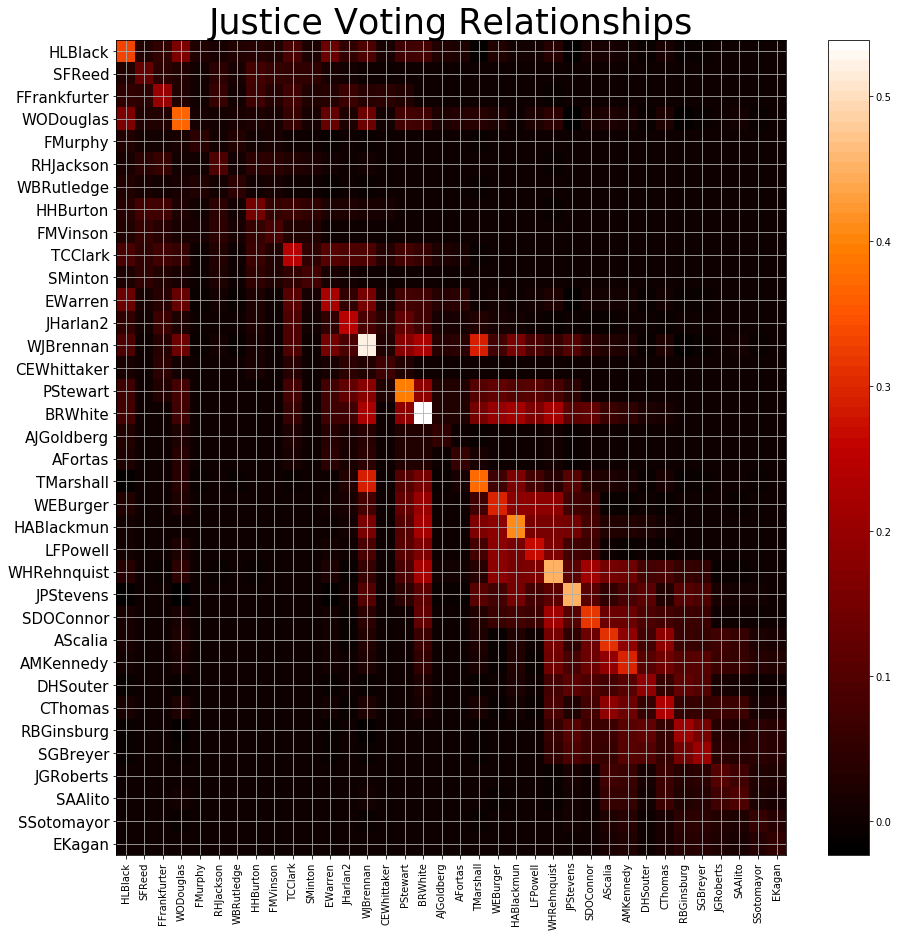

In [19]:
from matplotlib import cm as cm
fig = plt.figure(figsize=(15,15))
ax1 = fig.add_subplot(111)
cmap = cm.get_cmap('gist_heat', 80)
cax = ax1.imshow(cov, interpolation="nearest", aspect='auto', cmap=cmap)
ax1.grid(True)
plt.title('Justice Voting Relationships', fontsize=35)
labels=[id_to_name[key] for key in cums.keys()]
x_ticks = plt.xticks(range(len(labels)), labels, rotation=90)
y_ticks = plt.yticks(range(len(labels)), labels, fontsize=15)
# ax1.set_xticklabels(labels,fontsize=12)
# ax1.set_yticklabels(labels,fontsize=15)
# Add colorbar, make sure to specify tick locations to match desired ticklabels
fig.colorbar(cax, ticks=[-0.5, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.55])
plt.show()

### Use RandomForests and RidgeClassifier to make predictions for each justice

## Plot shift over time

In [20]:
j_to_idx = {}
for j in cat.justice_ids:
    j_to_idx[j] = cat.justice_Y(j, which="all").index

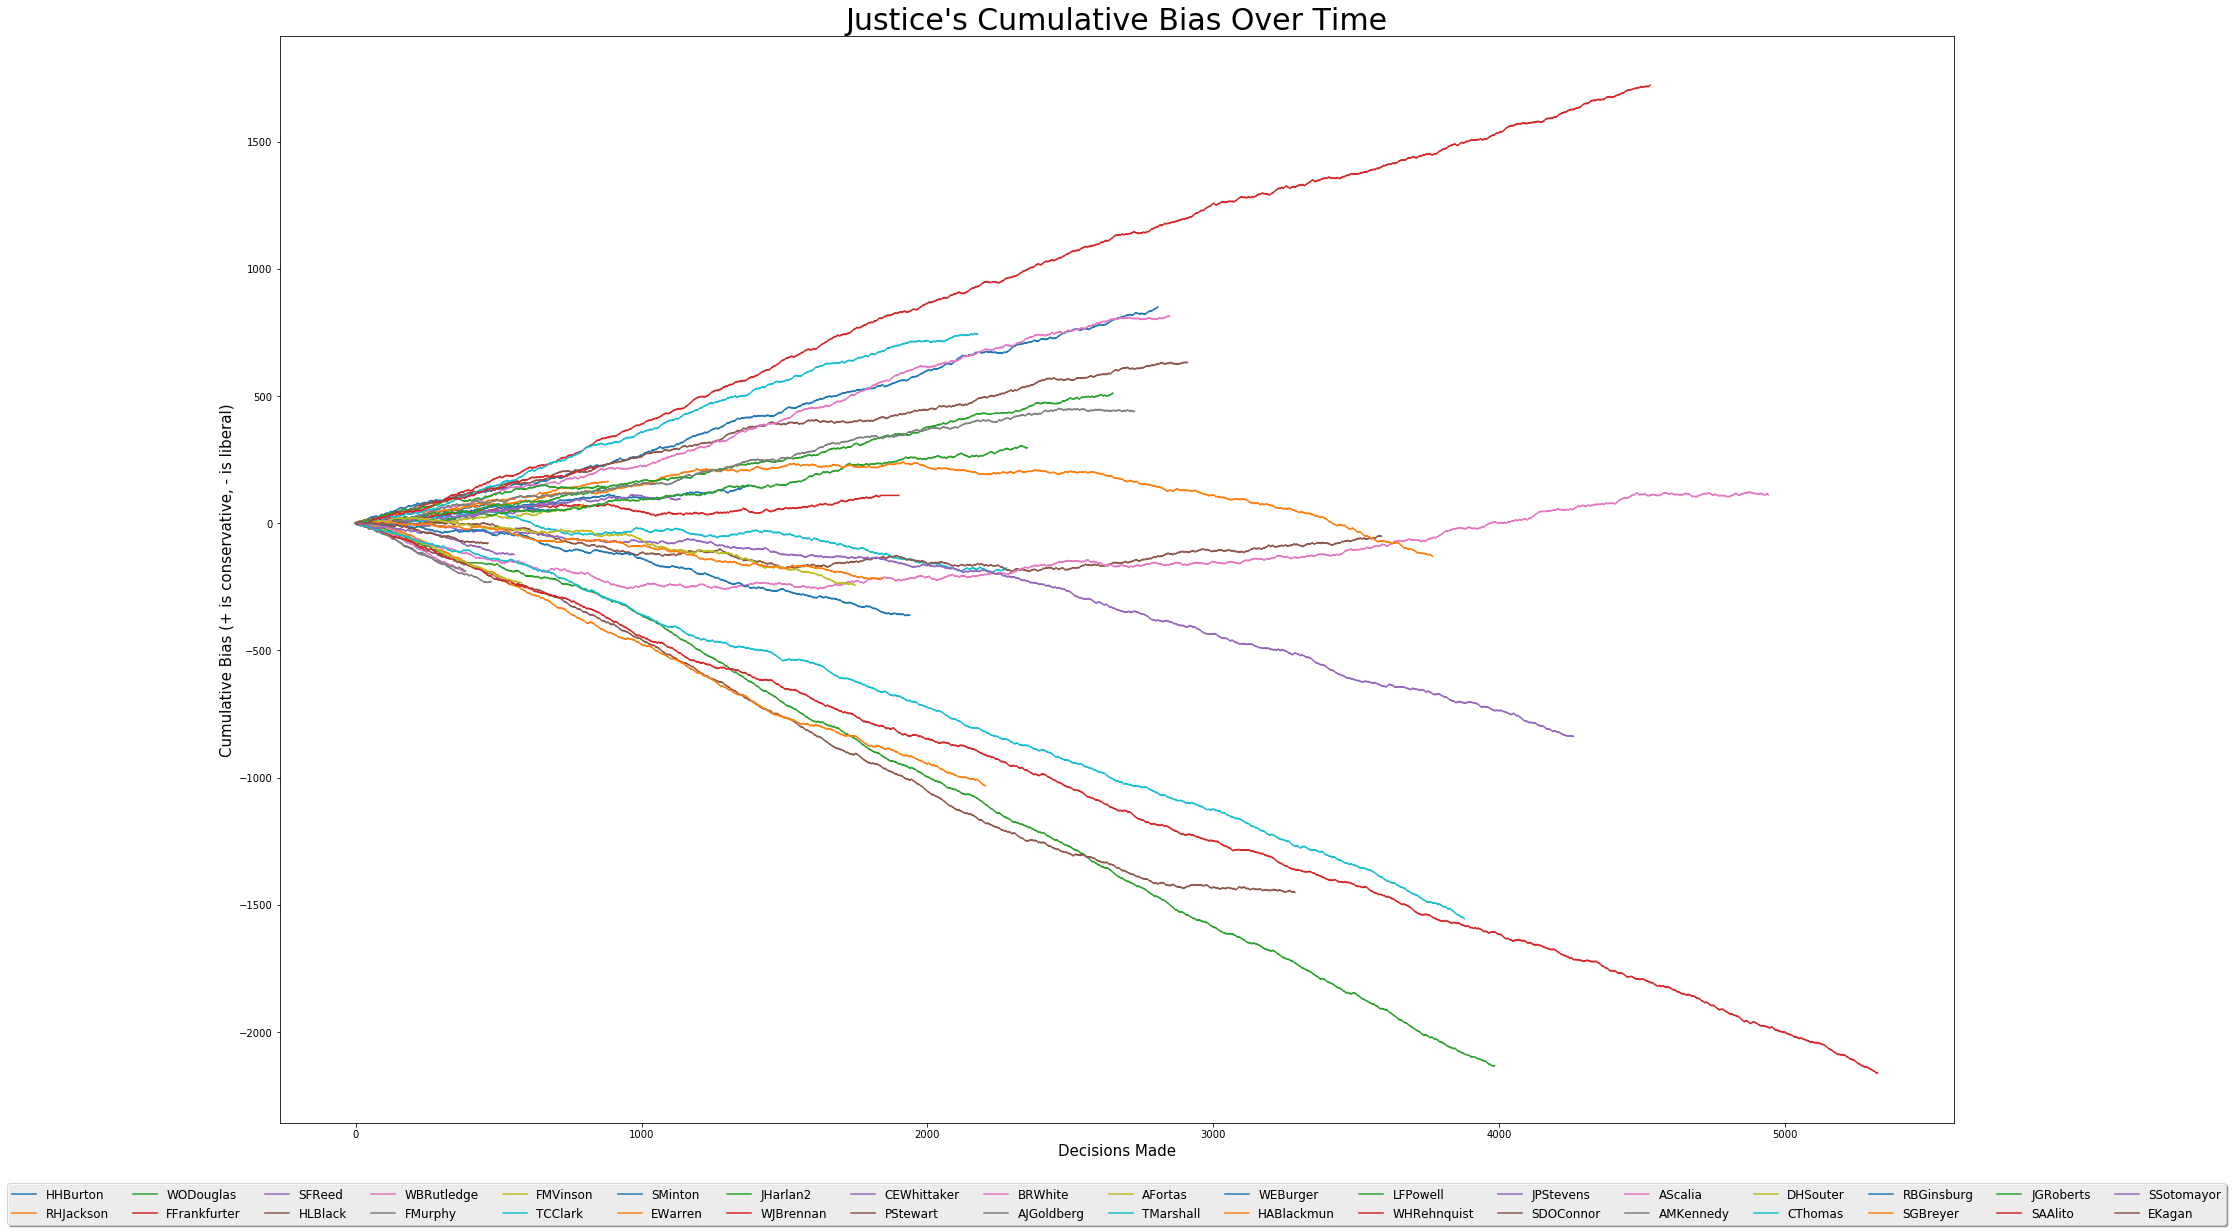

In [21]:
def plot_drift(ID):
    direction = np.array(cat.outcomes.loc[j_to_idx[ID], 'direction'])
    direction[np.where(direction == 2)] = -1
    cum = np.cumsum(direction)
    return cum

def plot_acc(ID):
    direction = np.array(cat.outcomes.loc[j_to_idx[ID], 'direction'])
    direction[np.where(direction == 2)] = -1
    acc = np.array(direction)
    return acc


cums = [plot_drift(i) for i in cat.justice_ids]
accs = [plot_acc(i) for i in cat.justice_ids]

# legend  = []
fig = plt.figure()
ax = plt.subplot(111)
for cum, name in zip(cums, cat.justice_ids):
#     print id_to_name[name], len(cum)
    ax.plot(cum, label=id_to_name[name])
#     legend.append(id_to_name[name])
box = ax.get_position()
ax.set_position([box.x0 + box.width * 0.5, box.y0 + box.height * 0.5,
                 box.width * 5.0, box.height * 5.0])

# Put a legend below current axis
ax.legend(loc='upper center', bbox_to_anchor=(0.5,-0.05) ,
             fancybox=True, shadow=True, ncol=18, fontsize=12)
# plt.legend(legend, loc='upper center')
plt.title('Justice\'s Cumulative Bias Over Time', fontsize=30)
plt.ylabel('Cumulative Bias (+ is conservative, - is liberal)', fontsize=15)
plt.xlabel('Decisions Made', fontsize=15)
plt.show()

## Add a temporal Element to the cumsum

/home/whinthorn/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


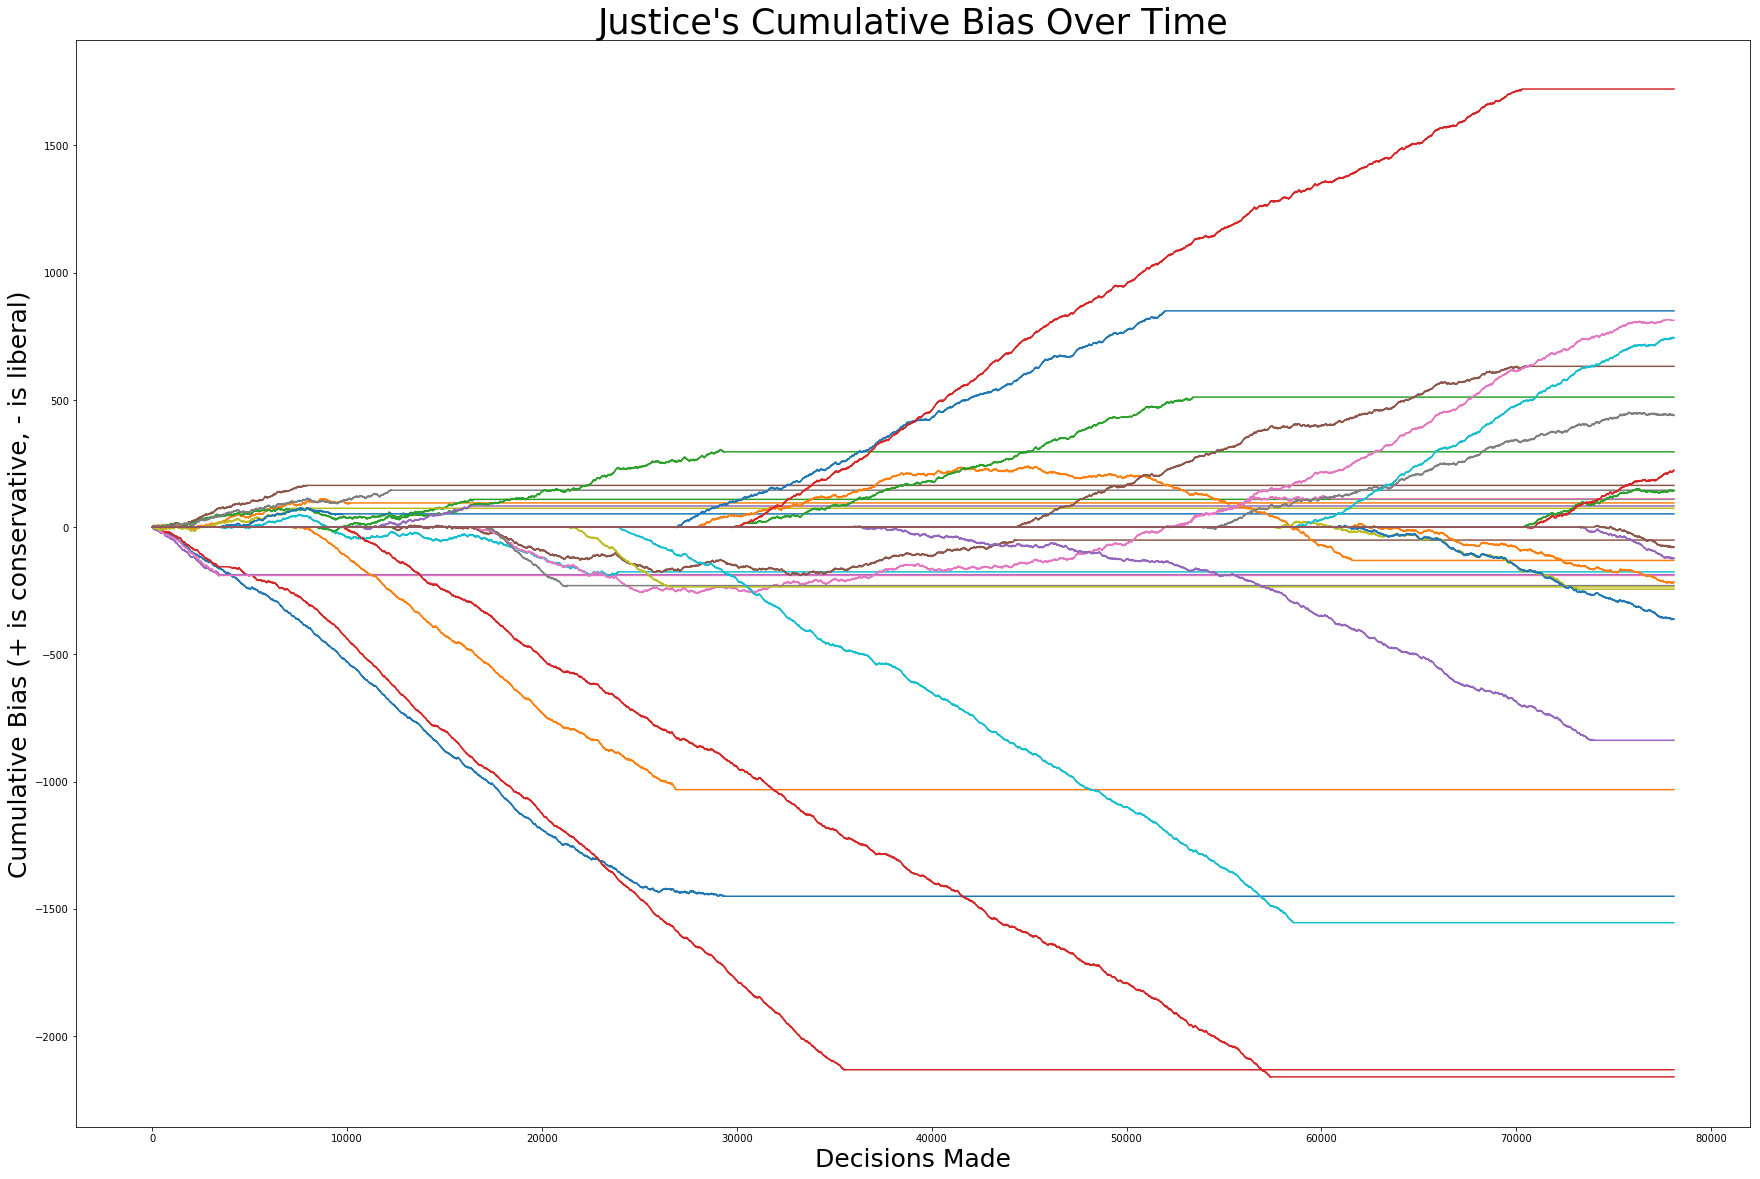

In [22]:
# legend  = []
fig = plt.figure()
ax = plt.subplot(111)

cums = {}
for j in cat.justice_ids:
    cums[j] = np.zeros(cat.outcomes.shape[0], dtype=int) 

for j, vote, i in zip(cat.ids['justice'], cat.outcomes['direction'], np.arange(cat.outcomes.shape[0])):
        (cums[j])[i] = -1 if vote ==2 else vote

for key, vec in cums.items():
    plt.plot(np.cumsum(vec))
box = ax.get_position()
ax.set_position([box.x0 + box.width * 0.5, box.y0 + box.height * 0.5,
                 box.width * 5.0, box.height * 5.0])

# Put a legend below current axis
ax.legend(loc='upper center', bbox_to_anchor=(0.5,-0.05) ,
             fancybox=True, shadow=True, ncol=18, fontsize=12)
# plt.legend(legend, loc='upper center')
plt.title('Justice\'s Cumulative Bias Over Time', fontsize=35)
plt.ylabel('Cumulative Bias (+ is conservative, - is liberal)', fontsize=25)
plt.xlabel('Decisions Made', fontsize=25)
plt.show()

# plt.plot(cums)
plt.show()

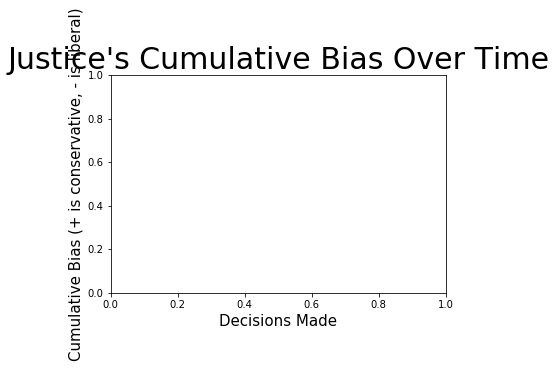

In [23]:
for cum, name in zip(cums, cat.justice_ids):
#     print id_to_name[name], len(cum)
    ax.plot(cum, label=id_to_name[name])
#     legend.append(id_to_name[name])
box = ax.get_position()
ax.set_position([box.x0 + box.width * 0.5, box.y0 + box.height * 0.5,
                 box.width * 5.0, box.height * 5.0])

# Put a legend below current axis
ax.legend(loc='upper center', bbox_to_anchor=(0.5,-0.05) ,
             fancybox=True, shadow=True, ncol=18, fontsize=12)
# plt.legend(legend, loc='upper center')
plt.title('Justice\'s Cumulative Bias Over Time', fontsize=30)
plt.ylabel('Cumulative Bias (+ is conservative, - is liberal)', fontsize=15)
plt.xlabel('Decisions Made', fontsize=15)
plt.show()

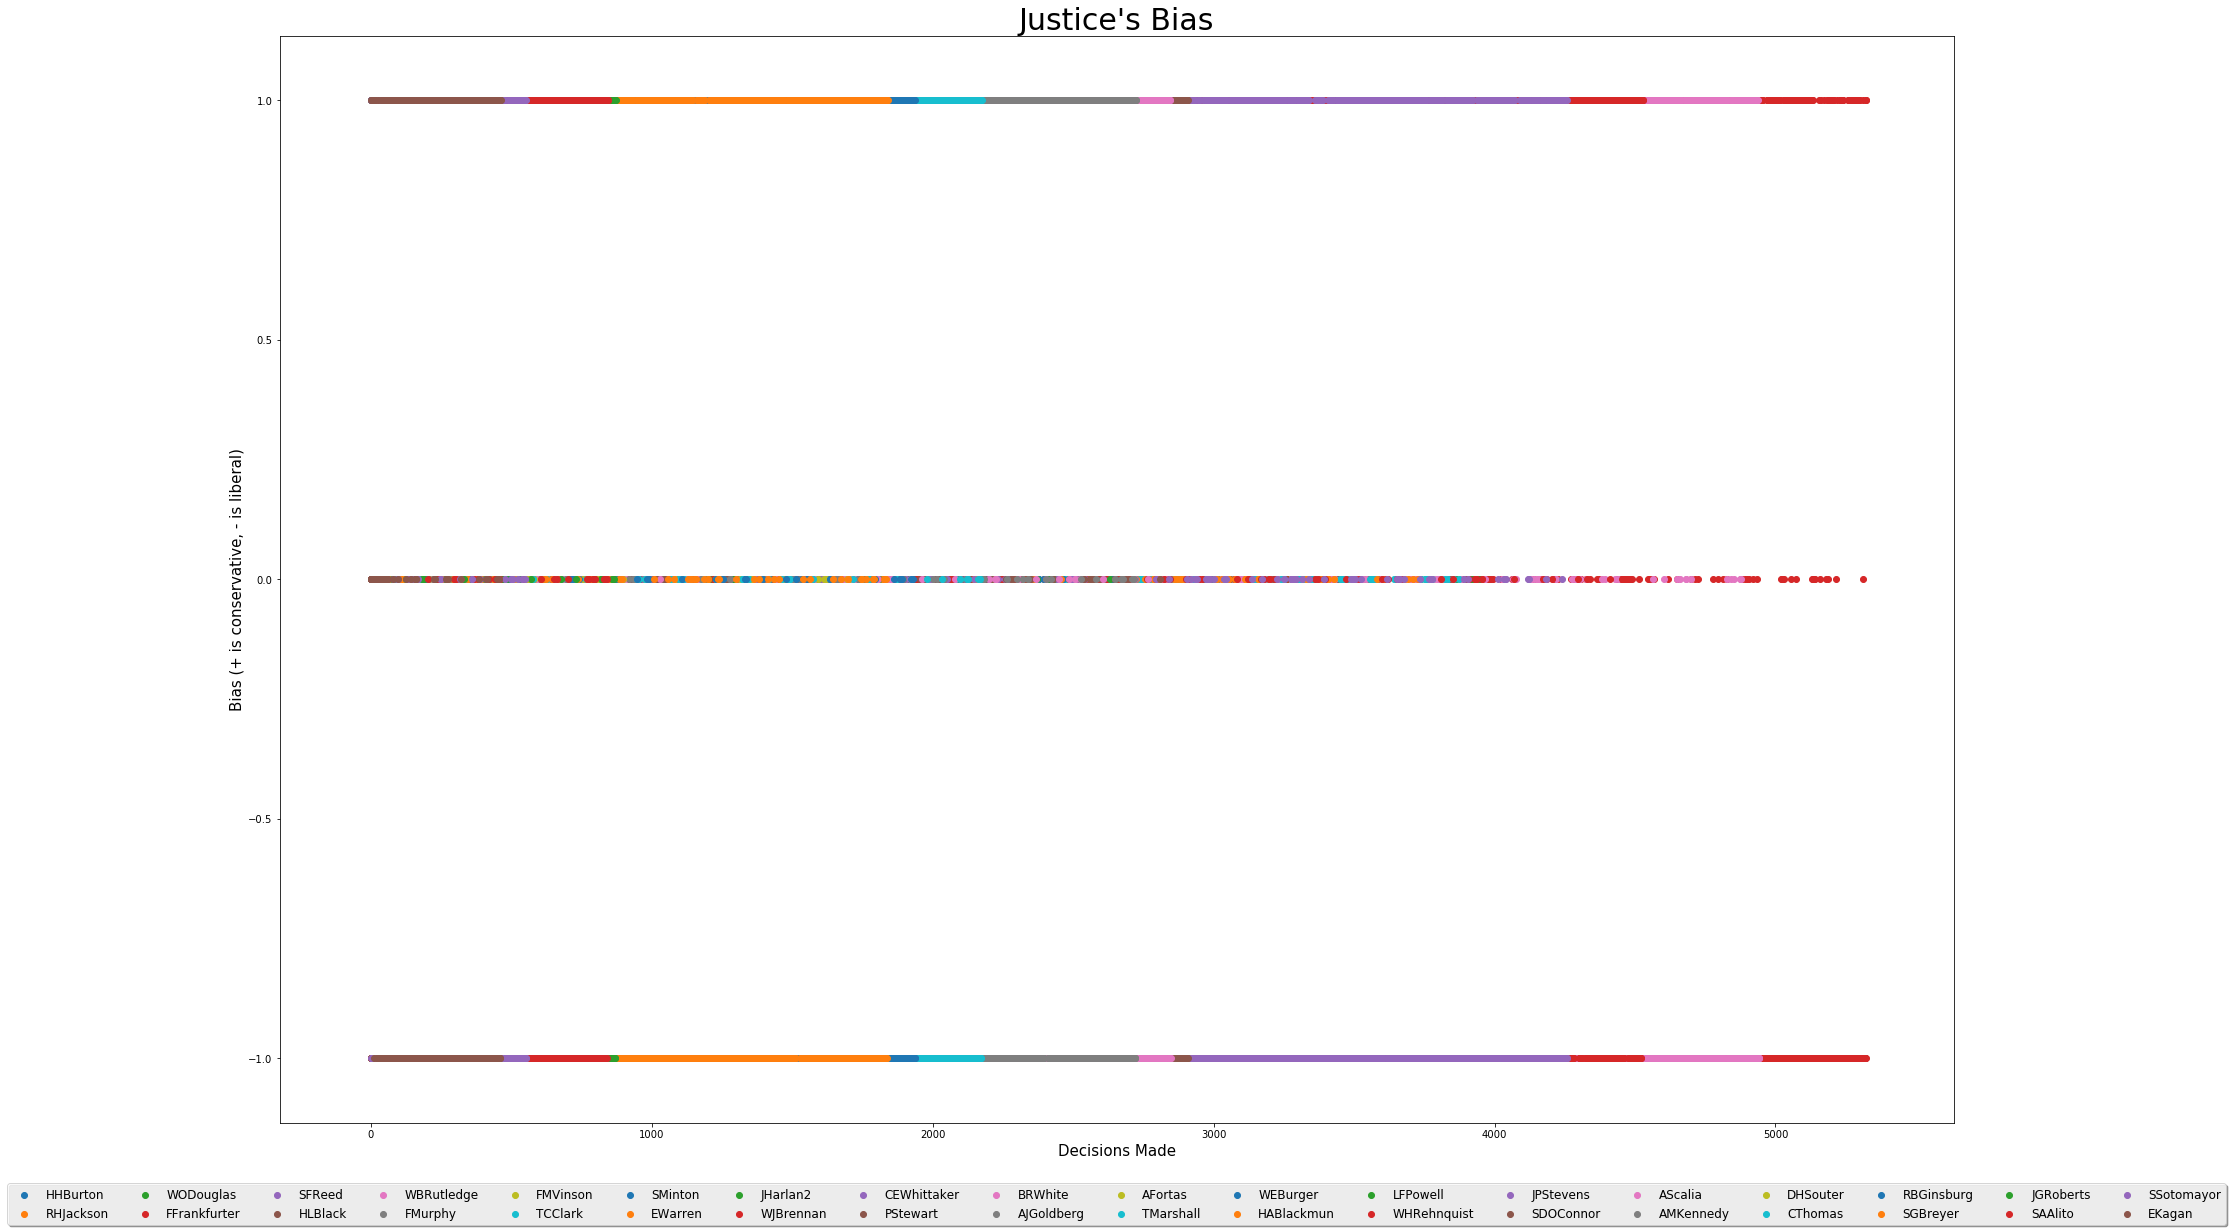

In [24]:
# legend  = []
fig = plt.figure()
ax = plt.subplot(111)
for acc, name in zip(accs, cat.justice_ids):
    ax.scatter(np.arange(len(acc)), acc, label=id_to_name[name])
#     legend.append(id_to_name[name])
box = ax.get_position()
ax.set_position([box.x0 + box.width * 0.5, box.y0 + box.height * 0.5,
                 box.width * 5.0, box.height * 5.0])

# Put a legend below current axis
ax.legend(loc='upper center', bbox_to_anchor=(0.5,-0.05) ,
             fancybox=True, shadow=True, ncol=18, fontsize=12)
# plt.legend(legend, loc='upper center')
plt.title('Justice\'s Bias', fontsize=30)
plt.ylabel('Bias (+ is conservative, - is liberal)', fontsize=15)
plt.xlabel('Decisions Made', fontsize=15)
plt.show()

In [25]:
deltas = []
for cum in cums:
    n = len(cum)
    deltas.append(np.zeros())
    for i in range(1, n):
        deltas

TypeError: object of type 'numpy.int64' has no len()

rfc = RandomForestClassifier(verbose=True, n_estimators=100,n_jobs=-1 )

rfc = rfc.fit(cat.feature_array(), cat.label_array())
rfc.score(cat.feature_array(which='test'), cat.label_array(which='test'))

rfc = RandomForestClassifier(verbose=True, n_estimators=100,n_jobs=-1 )

rfc = rfc.fit(cat.train_feat, cat.label_array())
rfc.score(cat.test_feat, cat.label_array(which='test'))

rfc = RandomForestClassifier(verbose=True, n_estimators=100,n_jobs=-1 )

rfc = rfc.fit(cat.train_feat_cont, cat.label_array())
rfc.score(cat.test_feat_cont, cat.label_array(which='test'))

rfc = RandomForestClassifier(verbose=True, n_estimators=100,n_jobs=-1 )

rfc = rfc.fit(cat.train_feat_ohe, cat.label_array())
rfc.score(cat.test_feat_ohe, cat.label_array(which='test'))

predictions = rfc.predict(cat.feature_array())
probs = rfc.predict_proba(cat.feature_array(which='test'))
print predictions
print probs

print np.sum(predictions == 1)
print np.sum(predictions == 0)
print np.sum(predictions == 2)
print probs

rfc = RandomForestClassifier(verbose=True, n_estimators=100,n_jobs=-1 )
rfc = rfc.fit(cat.feature_array(), cat.label_array())
rfc.score(cat.feature_array(which='test'), cat.label_array(which='test'))

predictions = rfc.predict(cat.feature_array(which='test'))
probs = rfc.predict_proba(cat.feature_array(which='test'))
print predictions
print probs


## Working Outline

* In progress...

The lack of data would indicate that an rnn may not be a particularly appropriate model for this task; however it would be fun to try in order to see how the sequence of issues or the long-term trends of a justice come into play for future decisions. 

### Workflow:

#### Data Preparation:

Impute values -> maybe categorize nan's as -1, etc. (There are no negative values here)

OHE categorical variables

Drop the justiceName column -> all information is in 'justice'


#### RNN